# NLP Super Stars --  A Natural Language Processing Project
Jared Vahle, Joshua Bryant, Hector Rodriguez, Sarah Lawson Woods - November 2021

In [1]:
import requests
from bs4 import BeautifulSoup 

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import re
from pprint import pprint

from wordcloud import WordCloud
from modeling import *

import os
import json

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from prepare import *

import nltk
import nltk.sentiment

import warnings


In [2]:
warnings.filterwarnings('ignore')
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')
sia = nltk.sentiment.SentimentIntensityAnalyzer()

# Acquire

In [3]:
# pulling in the data from a json that included all the readme's in the repo list
data = pd.read_json('data.json')

In [4]:
# taking a look at the contents
data.head()

,repo,language,readme_contents
0,thedaviddias/Front-End-Checklist,None,"<h1 align=""center"">\n<br>\n <img src=""https:/..."
1,onevcat/Kingfisher,Swift,"<p align=""center"">\n<img src=""https://raw.gith..."
2,FallibleInc/security-guide-for-developers,None,# 实用性 WEB 开发人员安全须知 \n\n### 目标读者 \n\n安全问题主要由以...
3,tailwindlabs/tailwindcss,JavaScript,"<p>\n <a href=""https://tailwindcss.com/"" ta..."
4,codepath/android_guides,None,# CodePath Android Cliffnotes\n\nWelcome to th...


### Acquire Takeaway
- The data was acquired by scaping the starred repos on GitHub number 1001-1009 and then 10010-10060; we chose these specific repos in order to avoid the first ones that mostly included guides and some unfinished products, we also wanted to make sure we had some variety so we pulled some that were further down the list.
- We brought in 506 rows initially 

# Prepare

In [5]:
# Let's check for missing values in the language column
data.isna().sum()

repo                0
language           54
readme_contents     0
dtype: int64

In [6]:
# removed languages that were 'none'
data = data.dropna()

In [7]:
len(data)

506

In [8]:
# Let's see what values we have for each type of language
data.language.value_counts()

JavaScript          141
Python               59
Java                 46
TypeScript           45
Go                   36
C++                  30
C                    20
Shell                13
Swift                13
HTML                 12
Rust                 11
Kotlin                9
Ruby                  9
C#                    9
PHP                   6
Vue                   6
Vim script            6
Jupyter Notebook      6
CSS                   5
Objective-C           3
TeX                   2
CoffeeScript          2
Lua                   2
Haskell               2
Elixir                2
Makefile              1
Rascal                1
Dockerfile            1
Emacs Lisp            1
AsciiDoc              1
Standard ML           1
Crystal               1
Clojure               1
OCaml                 1
Batchfile             1
Dart                  1
Name: language, dtype: int64

In [9]:
# brought the dataset down to those languages that were more than or equal to 30
data = data[data['language'].map(data['language'].value_counts()) >= 30]

In [10]:
# Check out the number of repos we will be examining
len(data)

357

### Language Counts

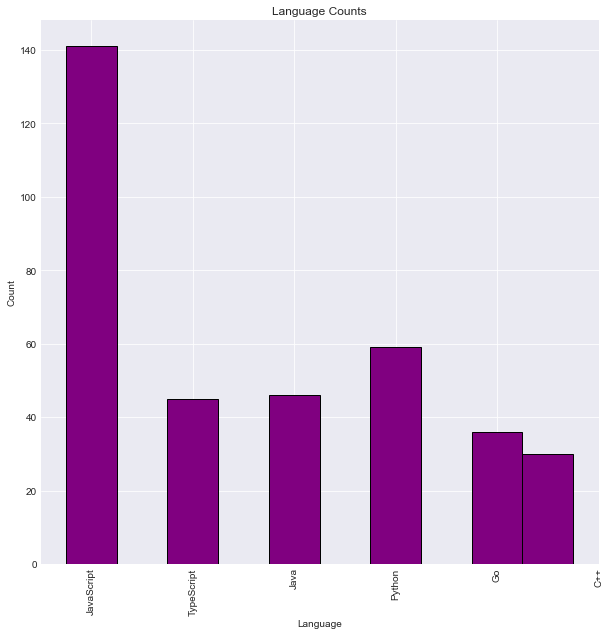

In [11]:
plt.figure(figsize=(10, 10))
data.language.hist(align = 'left', color = 'purple', ec = 'k')
plt.title('Language Counts')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

In [12]:
# Here we checked to make sure all of the null values were removed above by our drop 
data.isna().sum()

repo               0
language           0
readme_contents    0
dtype: int64

In [13]:
# Next we use our prep function that takes in a df and the string name for a text column with the option to 
# pass lists for extra_words and exclude_words and returns a df with the readme text, original text and stemmed 
# text, lemmatized text, cleaned, tokenized, & lemmatized text with stopwords removed.
data = prep_readme_data(df= data, column = 'readme_contents', extra_words=['https','p','com','http','href'], exclude_words=[])

KeyboardInterrupt: 

In [ ]:
# At this point we dropped the original contents since we had it in all the forms we need for exploration and 
# modeling
data = data.drop(columns = ['readme_contents'])

In [ ]:
# This function gives us message length, word count and average word length added as columns to the df
data = get_columns(data)

In [ ]:
# Here we made a column named is_javascript to hold all rows that the language column indicated were javascript
data['is_javascript'] = data.apply(lambda row: is_javascript(row), axis=1)

In [ ]:
# And here we made a column named sentiment to tell us the aggregate sentiment of the 
# text of each readme
data['sentiment'] = data.clean.apply(lambda doc: sia.polarity_scores(doc)['compound'])

In [ ]:
# Taking a look at the modified data
data

In [ ]:
# Splitting our data for exploration
train, test = train_test_split(data, train_size = 0.8, random_state = 123, stratify=data.is_javascript)

### Takeaways
- In the stage of the pipeline we checked for null values and dropped all rows missing a value in the language column since we had more than enough rows without the 54 that we ended up dropping here
- We then looked at the value counts for each language and decided to drop all the languages that contained less than 30 readme's because we didnt want there to be a problem stratifying the sparse languages in each section of the split dataset
- The next step was to use our prep function stored in the prepare file that takes in a df and the string name for a text column with the option to pass lists for extra_words and exclude_words and returns a df with the readme text, cleaned text, stemmed text, lemmatized text, with stopwords removed from all columns.
- Next we removed the readme_contents column since we had no more use for it in explore or modeling
- We then used the get_columns function to give us message length, word count and average word length added as columns to the df
- We also created two columns named is_javascript to hold all rows that the language column indicated were javascript and a sentiment column to tell us the aggregate sentiment of the text of each readme
- Split our data on train and test


# Explore 

- We know that JavaScript makes up near 40% of the readme with the other 60% being non JavaScript

In [ ]:
# Let's look at the language of each readme by percentage
train.language.value_counts(normalize = True)

In [ ]:
# Taking a lookt at the number of readme's by language after the modifications in prepare
train.language.value_counts()

In [ ]:
# Displaying the index dtype and columns, non-null values and memory usage
train.info()

In [ ]:
# Generate descriptive statistics
train.describe()

In [ ]:
# combine all messages in single string by label
JavaScript_words = clean(' '.join(train[train.language == 'JavaScript'].stemmed))
Python_words = clean(' '.join(train[train.language == 'Python'].stemmed))
TS_words = clean(' '.join(train[train.language == 'TypeScript'].stemmed))
Java_words = clean(' '.join(train[train.language == 'Java'].stemmed))
Go_words = clean(' '.join(train[train.language == 'Go'].stemmed))
C_words = clean(' '.join(train[train.language == 'C++'].stemmed))
Non_JavaScript = clean(' '.join(train[train.language != 'JavaScript'].stemmed))
all_words = clean(' '.join(train.stemmed))

# making a df for each language 
js_df = data[data.language == 'JavaScript']
python_df = data[data.language == 'Python']
java_df = data[data.language == 'Java']
ts_df = data[data.language == 'TypeScript']
go_df = data[data.language == 'Go']
c_df = data[data.language == 'C++']

In [ ]:
# Looking at the frequency of word that appeared in the TypeScript readme
TS_freq = pd.Series(TS_words.split()).value_counts()
TS_freq

In [ ]:
#Represent text as word frequencies
JavaScript_freq = pd.Series(JavaScript_words.split()).value_counts()
Python_freq = pd.Series(Python_words.split()).value_counts()
Java_freq = pd.Series(Java_words.split()).value_counts()
Go_freq = pd.Series(Go_words.split()).value_counts()
C_freq = pd.Series(C_words.split()).value_counts()
TS_freq = pd.Series(TS_words.split()).value_counts()
non_JavaScript_freq = pd.Series(Non_JavaScript.split()).value_counts()
all_words_freq = pd.Series(all_words.split()).value_counts()

In [ ]:
# Created a dataframe of the word frequencies as they occurred above to include grand totals
word_counts = pd.concat([JavaScript_freq, Python_freq, Java_freq, Go_freq, C_freq, TS_freq,non_JavaScript_freq, all_words_freq], axis = 1).fillna(0).astype(int)
word_counts.columns = ['javascript','python','java','go','c','ts','NonJS','all']
word_counts.head()

In [ ]:
# Here we put them in order from highest to lowest occurrences by total count in the all column
word_counts.sort_values('all', ascending = False).head(20)

In [ ]:
# Then we just sorted by NonJS and javascript columns only
word_counts.sort_values(['NonJS','javascript'],ascending = [True,False]).head(20)


In [ ]:
# Here we sorted by javascript and then NonJS
word_counts.sort_values(['javascript','NonJS'],ascending = [True,False]).head(20)

## Top 20

In [ ]:
# Displayed the 20 most frequent word list by Non Javascript vs JavaScript
plt.rc('font', size=16)
word_counts.sort_values('NonJS', ascending=False).head(20)[['javascript','NonJS']].plot.barh(stacked = True, ec = 'k')#stacked and added bar border
plt.title('Top 20 Most Frequent Word List: Non JavaScript vs JavaScript')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.legend(['JavaScript', 'Non JavaScript'], fontsize = 15)
plt.show()

In [ ]:
# Displayed the 20 most frequent word list by Javascript vs Non JavaScript
plt.rc('font', size=16)
word_counts.sort_values('javascript', ascending=False).head(20)[['javascript','NonJS']].plot.barh(stacked = True, ec = 'k')#stacked and added bar border
plt.title('Top 20 Most Frequent Word List: JavaScript vs Non JavaScript')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.legend(['JavaScript', 'Non JavaScript'], fontsize = 15)
plt.show()

## Top 20 Distribution

In [ ]:
# Plotted the distribution percentages per word by language
plt.figure(figsize=(16, 9))
plt.rc('font', size=15)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'javascript')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('Top 20 Distribution Percentage per Word')
plt.xlabel('Distribution Percentage')
plt.ylabel('Word')
plt.legend(['JavaScript', 'Python', 'Java', 'Go', 'C', 'TS', 'Non JavaScript'])
plt.show()

## Bigrams

In [ ]:
# Plotted the top 10 JavaScript bigrams
pd.Series(nltk.bigrams(JavaScript_words.split())).value_counts().head(10).plot.barh(color = 'blue',ec = 'k')
plt.title('Top 10 JavaScript bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')
plt.show()

In [ ]:
# Displaying the top Java bigrams
pd.Series(nltk.bigrams(Java_words.split())).value_counts().head(10).plot.barh(color = 'green',ec = 'k')#change bar color to reflect stacked chart above and outline
plt.title('Top 10 Java bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')
plt.show()

In [ ]:
# Plotting the top 10 bigrams
pd.Series(nltk.bigrams(Python_words.split())).value_counts().head(10).plot.barh(color = 'orange',ec = 'k')#change bar color to reflect stacked chart above and outline
plt.title('Top 10 Python bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')
plt.show()

In [ ]:
# Displaying the top 10 Non JavaScipt bigrams
pd.Series(nltk.bigrams(Non_JavaScript.split())).value_counts().head(10).plot.barh(color = 'pink',ec = 'k',)
plt.title('Top 10 Non JavaScript bigrams')
plt.xlabel('Count')
plt.ylabel('bigrams')
plt.show()

## Clouds

In [ ]:
# Creating a wordcloud for JavaScript words
img = WordCloud(background_color='white', width=800, height=600).generate(JavaScript_words)
plt.title('JavaScript Wordcloud')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Displaying a Non JavaScript wordcloud
img = WordCloud(background_color='white', width=800, height=600).generate(Non_JavaScript)
plt.title('Non JavaScript Wordcloud')
plt.imshow(img)
plt.axis('off')
plt.show()

## Relational Plots

### Language Relationships

In [ ]:
# Created a relpot to display word count to message length relationship between languages
plot = sns.relplot(data = train, x = 'message_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 4000))
plot.set(xlim=(0,50000))
plt.title('Word Count to Message Length Relationship Between Languages')
plt.xlabel('Message Length')
plt.ylabel('Word Count')
plt.show()

#### Language Narrowed in Limits

In [ ]:
# A closer look at the above visualization
plot = sns.relplot(data = train, x = 'message_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 1000))
plot.set(xlim=(0,15000))
plt.title('Word Count to Message Length Relationship Between Languages')
plt.xlabel('Message Length')
plt.ylabel('Word Count')
plt.show()

### JavaScript Relationships

In [ ]:
# Creating a relplot to display word count to message length relationship whether or not language is Javascript
plot = sns.relplot(data = train, x = 'message_length', y = 'word_count', hue = 'is_javascript', height = 8, aspect = 1.5)
plot.set(ylim=(0, 1000))
plot.set(xlim=(0,15000))
plt.title('Word Count to Message Length Relationship Whether or Not Language is Javascript')
plt.xlabel('Message Length')
plt.ylabel('Word Count')
plt.show()

#### Is_JavaScript Narrowed in limits

In [ ]:
# A closer look at the above visualization
plot = sns.relplot(data = train, x = 'message_length', y = 'word_count', hue = 'is_javascript', height = 8, aspect = 1.5)
plot.set(ylim=(0, 4000))
plot.set(xlim=(0,50000))
plt.title('Word Count to Message Length Relationship Whether or Not Language is Javascript')
plt.xlabel('Message Length')
plt.ylabel('Word Count')
plt.show()

### Average Word Relationships

In [ ]:
# Creating a replot of word count to message length with a hue of languages
plot = sns.relplot(data = train, x = 'avg_word_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 4000))
plot.set(xlim=(5,40))
plt.title('Word Count to Message Length Relationship Between Languages')
plt.xlabel('Average Word Length')
plt.ylabel('Word Count')
plt.show()

#### Average Narrowed in Limits

In [ ]:
# Creating a relplot of word count to message length with a hue of languages
plot = sns.relplot(data = train, x = 'avg_word_length', y = 'word_count', hue = 'language', height = 8, aspect = 1.5)
plot.set(ylim=(0, 5000))
plot.set(xlim=(6,15))
plt.title('Word Count to Message Length Relationship Between Languages')
plt.xlabel('Average Word Length')
plt.ylabel('Word Count')
plt.show()

In [ ]:
# Here we displayed the median and mean of message length, word count and sentiment in a df
train.groupby('language')['message_length','word_count','sentiment'].agg(['mean','median'])

In [ ]:
# Next we grouped by whether or not they were Javascript or not
train.groupby('is_javascript').agg(['mean','median'])

## Sentiment Values

In [ ]:
# This is plot of the compound aggregate sentiment by language
sns.barplot(data = train, x = 'sentiment', y = 'language', hue = 'is_javascript')
plt.title('Sentiment Values')
plt.xlabel('Sentiment')
plt.ylabel('Language')
plt.legend(loc = 'upper right', title = 'Language')
plt.show()

### Takeways
- We know that JavaScript makes up near 40% of the readme's with the other 60% being non JavaScript
- JS takes up 40%
- Top 5 JS - use, javascript, j, function, file
- Top 5 Non JS - use, opensourc, instal, file, softwareoss
- Top 3 JS bigrams are (api, version), (j, const), (nom, instal)
- Top 3 NJS bigrams are (opensourc, softwareoss), ( open, source), (1,2) 
- JS Wordclouds top 3 use, file, JavaScript 
- NJS wc t3 most common use, opensourc, softwareoss
- Average word length
- AVG JS is 885
- Avg NJS is 779
- AVG JS Sentiment 86%
- AVG NJS Sentiment 79%

# Modeling

In [ ]:
# Bag of words
cv = CountVectorizer()
bag_of_words = cv.fit_transform(data.clean)

In [ ]:
bag_of_words.todense()

In [ ]:
pprint(data)

In [ ]:
# TFIDF 
tfidf = TfidfVectorizer()
bag_of_words = tfidf.fit_transform(data.clean)

pd.DataFrame(bag_of_words.todense(), columns=tfidf.get_feature_names()).sample(20)

In [ ]:
pd.Series(dict(zip(tfidf.get_feature_names(), tfidf.idf_))).sort_values()

In [ ]:
# Establishing our baseline on train
train.is_javascript.value_counts(normalize = True)

We chose to go with mode of our 'is_javascript' target variable to get our baseline

In [ ]:
# Baseline: ~60.5

In [ ]:
# Using Clean, Stemmed, lemmatized data on a MultinomialNB, and DecisionTreeClassifier.

In [ ]:
# Getting the cleaned data
X = data
y = 'is_javascript'

X_train_clean, X_train_stemmed, X_train_lemmatized, y_train, X_test_clean, X_test_stemmed, X_test_lemmatized, y_test = data_split(X, y)

In [ ]:
# Cleaned data with a MultinomialNB and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_clean)
clf = MultinomialNB(alpha=.01)
clf.fit(X_bow, y_train)

clf.score(X_bow, y_train)

In [ ]:
# Cleaned data with a MultinomialNB and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_clean)
clf = MultinomialNB(alpha=.01)
clf.fit(X_tfidf, y_train)

clf.score(X_tfidf, y_train)

In [ ]:
# Cleaned data with a Decision Tree classifier and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_clean)
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_bow, y_train)

tree.score(X_bow, y_train)

In [ ]:
# Cleaned data with a Decision Tree classifier and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_clean)
tree.fit(X_tfidf,y_train)
tree.score(X_tfidf,y_train)

In [ ]:
# Stemmed data with a MultinomialNB and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_stemmed)
clf = MultinomialNB(alpha=.01)
clf.fit(X_bow, y_train)

clf.score(X_bow, y_train)

In [ ]:
# Stemmed data with a MultinomialNB and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_stemmed)
clf = MultinomialNB(alpha=.01)
clf.fit(X_tfidf, y_train)

clf.score(X_tfidf, y_train)

In [ ]:
# Stemmed data with a Decision Tree classifier and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_stemmed)
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_bow, y_train)

tree.score(X_bow, y_train)

In [ ]:
# Stemmed data with a Decision Tree classifier and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_stemmed)
tree.fit(X_tfidf,y_train)
tree.score(X_tfidf,y_train)

In [ ]:
# Lemmatized data with a MultinomialNB and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_lemmatized)
clf = MultinomialNB(alpha=.01)
clf.fit(X_bow, y_train)

clf.score(X_bow, y_train)

In [ ]:
# Lemmatized data with a MultinomialNB and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_lemmatized)
clf = MultinomialNB(alpha=.01)
clf.fit(X_tfidf, y_train)

clf.score(X_tfidf, y_train)

In [ ]:
# Lemmatized data with a Decision Tree classifier and a count vectorizer
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train_lemmatized)
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_bow, y_train)

tree.score(X_bow, y_train)

In [ ]:
# Lemmatized data with a Decision Tree classifier and a TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train_lemmatized)
tree.fit(X_tfidf,y_train)
tree.score(X_tfidf,y_train)

In [ ]:
tree.score(tfidf.transform(X_test_clean), y_test)

In [ ]:
predictions = make_predictions(clf,X_train_clean,X_test_clean,y_train)

In [ ]:
# uses count vectorization on the cleaned data and makes a model report on the test predictions using a multinomialNB
model_report(y_test, predictions)

### Takeaways
- Our best model was a Multinomial Naive Bayes model using count vectorization that performed with an accuracy of 81.94% on unseen data, beating our baseline by 21.44%

# Conclusion

Most of our conclusions were drawn in the exploration phase where we saw differences in distribution of words amongst the different programming languages. We also saw differences in the bigrams for different languages, but decided the most common words would be more useful during modeling.